In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()


'/device:GPU:0'

In [2]:
from google.colab import drive                 # mount google drive to upload dataset
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. First check given image is of car or not?

In [4]:
# Import Libraries

import numpy as np
import json

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input

from collections import Counter, defaultdict
import os
import pickle as pk
%matplotlib inline
from IPython.display import Image

Using TensorFlow backend.


In [0]:
#Upload VGG16 model 

vgg16 = VGG16(weights='imagenet')





553467904/553467096 [==============================] - 6s 0us/step








In [0]:
#save the model
vgg16.save('/content/drive/My Drive/car_damage_detection/vgg16.h5')
print('vgg16 saved...')

vgg16 saved...


* Here we are using pre-trained model vgg16. So we have to resize the input to the same format the network was originally trained on which is 224 x 224

In [0]:
# scale the image 
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))      # load image
    x = img_to_array(img)                                 # convert the image pixels to a numpy array
    x = np.expand_dims(x, axis=0)                         # adding the extra dimension
    x = preprocess_input(x)                               # prepare the image for the VGG model
    return x

#### Testing with model vgg16

In [0]:
CLASS_INDEX = None
CLASS_INDEX_PATH = '/content/drive/My Drive/car_damage_detection/imagenet_class_index.json'            # JSON file contains 1000 categories  

In [0]:
def get_predictions(preds,top=5):                       # printing top 5 predictions
    
    global CLASS_INDEX
    CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))     #Load the json file

    #get the results
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

[[('n03100240', 'convertible', 0.7268434), ('n04285008', 'sports_car', 0.2047563), ('n02974003', 'car_wheel', 0.028446594), ('n04037443', 'racer', 0.026791846), ('n03459775', 'grille', 0.0044032377)]]


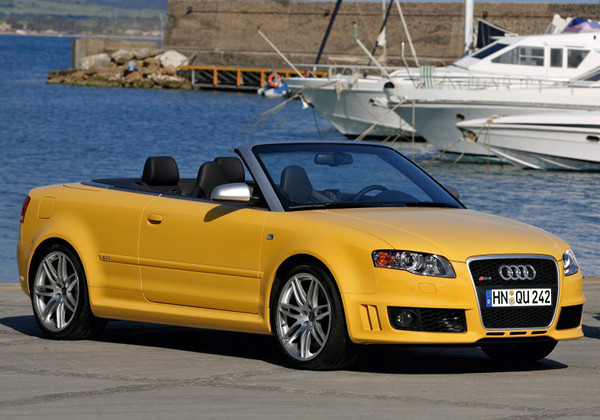

In [0]:
test1 = prepare_image('/content/drive/My Drive/car_damage_detection/test1.jpg')
test1_pred = vgg16.predict(test1)
print(get_predictions(test1_pred, top=5))
Image('/content/drive/My Drive/car_damage_detection/test1.jpg')

#### Category list creation:
- Extracting the most common categories related to car from json file.

In [0]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('/content/drive/My Drive/car_damage_detection/car-damage-dataset/data1/training/01-whole')
    for i, img_path in enumerate(img_list):
        img = prepare_image('/content/drive/My Drive/car_damage_detection/car-damage-dataset/data1/training/01-whole/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 100 == 0:
            print (i, '/', len(img_list), 'complete')
    return Counter(d)

In [0]:
cat_counter=get_car_categories()

0 / 920 complete
100 / 920 complete
200 / 920 complete
300 / 920 complete
400 / 920 complete
500 / 920 complete
600 / 920 complete
700 / 920 complete
800 / 920 complete
900 / 920 complete


In [0]:
cat_list  = [k for k, v in cat_counter.most_common()[:27]]    # categories from json file which are related to cars 
cat_list

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n03594945', 'jeep'),
 ('n03769881', 'minibus'),
 ('n04461696', 'tow_truck'),
 ('n03459775', 'grille'),
 ('n02930766', 'cab'),
 ('n02974003', 'car_wheel'),
 ('n03796401', 'moving_van'),
 ('n03977966', 'police_van'),
 ('n04252225', 'snowplow'),
 ('n02701002', 'ambulance'),
 ('n04065272', 'recreational_vehicle'),
 ('n04467665', 'trailer_truck'),
 ('n03445924', 'golfcart'),
 ('n03345487', 'fire_engine'),
 ('n03791053', 'motor_scooter'),
 ('n03776460', 'mobile_home'),
 ('n04252077', 'snowmobile'),
 ('n02704792', 'amphibian'),
 ('n03417042', 'garbage_truck'),
 ('n02965783', 'car_mirror')]

#### Check car or not: 
- If image prediction contains any category from cat_list then identify it as car, else identify it as not a car.

In [0]:
def car_categories_gate(image_path, cat_list):
    img = prepare_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print ("Validating that this picture is of car or not?")
    for j in top[0]:
        if j[0:2] in cat_list:
            print (j[0:2])
            return "Validation complete - This is car - proceed further "
    return "This picture could not identify any car in it. Please take another picture and try again."

In [0]:
car_categories_gate('/content/drive/My Drive/car_damage_detection/test1.jpg', cat_list)


Validating that this picture is of car or not?
('n03100240', 'convertible')


'Validation complete - This is car - proceed further '

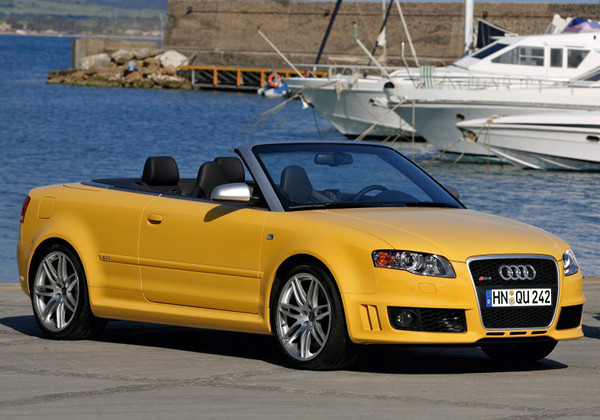

In [0]:
Image('/content/drive/My Drive/car_damage_detection/test1.jpg')

In [0]:
car_categories_gate('/content/drive/My Drive/car_damage_detection/test2.jpg', cat_list)

Validating that this picture is of car or not?


'This picture could not identify any car in it. Please take another picture and try again.'

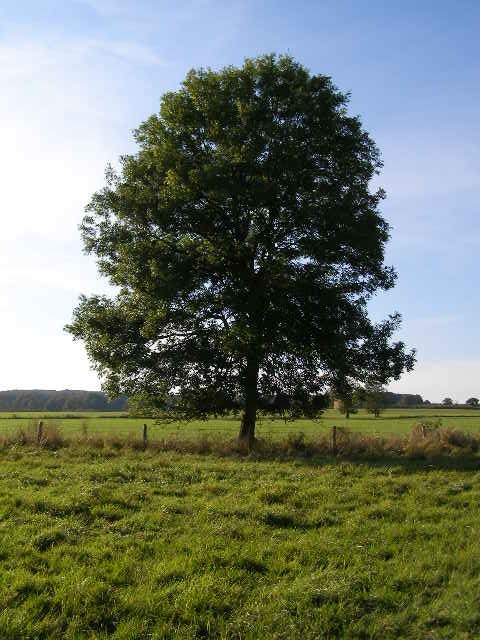

In [0]:
Image('/content/drive/My Drive/car_damage_detection/test2.jpg')

# 2. Car is damaged or whole? 

In [0]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [0]:
# path to the model weights file
location = '/content/drive/My Drive/car_damage_detection'
top_model_weights_path='/content/drive/My Drive/car_damage_detection/top_model_weights.h5' # will be saved into when we create our model
fine_tuned_model_path = '/content/drive/My Drive/car_damage_detection/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = '/content/drive/My Drive/car_damage_detection/car-damage-dataset/data1/training'
validation_data_dir = '/content/drive/My Drive/car_damage_detection/car-damage-dataset/data1/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
print(nb_train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)
print(nb_validation_samples)
nb_epoch = 50
batch_size=20

1840
460


In [0]:
datagen = ImageDataGenerator(rescale=1./255)  
    
print("loding vgg16....")
model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
print('vgg16 model loaded.')
model.summary()
    
generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=20, 
                                            class_mode=None, 
                                            shuffle=False) 
    
bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size, verbose = 1)
np.save(open('bottleneck_features_train', 'wb'), bottleneck_features_train)
    
# repeat with the validation data
generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=20,
                                           class_mode=None,
                                           shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size, verbose = 1)
np.save(open('bottleneck_features_validation', 'wb'), bottleneck_features_validation)

loding vgg16....
58892288/58889256 [==============================] - 1s 0us/step
vgg16 model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________

- Train binary model

In [0]:
train_data = np.load(open('bottleneck_features_train', 'rb'))
len(train_data)

1840

In [0]:
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
len(train_labels)

1840

In [0]:
validation_data = np.load(open('bottleneck_features_validation', 'rb'))
len(validation_data)

460

In [0]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
len(validation_labels)

460

In [0]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(1, activation = 'sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(optimizers.SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

In [0]:
history = model.fit(train_data, train_labels, nb_epoch=nb_epoch, batch_size=20, 
          validation_data=(validation_data, validation_labels), callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1840 samples, validate on 460 samples
Epoch 1/50
1840/1840 [==============================] - 1s 582us/step - loss: 0.5876 - acc: 0.6799 - val_loss: 0.4066 - val_acc: 0.8587

Epoch 00001: val_acc improved from -inf to 0.85870, saving model to /content/drive/My Drive/car_damage_detection/top_model_weights.h5
Epoch 2/50
1840/1840 [==============================] - 1s 370us/step - loss: 0.4162 - acc: 0.8228 - val_loss: 0.3423 - val_acc: 0.8630

Epoch 00002: val_acc improved from 0.85870 to 0.86304, saving model to /content/drive/My Drive/car_damage_detection/top_model_weights.h5
Epoch 3/50
1840/1840 [==============================] - 1s 370us/step - loss: 0.3694 - acc: 0.8418 - val_loss: 0.3078 - val_acc: 0.8826

Epoch 00003: val_acc improved from 0.86304 to 0.88261, saving model to /content/drive/My Drive/car_damage_detection/top_model_weights.h5
Epoch 4/50
1840/1840 [==============================] - 1s 368us/step - loss: 0.3552 - acc: 0.8478 - val_loss: 0.3027 - val_acc: 0.878

In [0]:
model.save_weights('/content/drive/My Drive/car_damage_detection/top_history.h5')
print("Saved model to disk")

Saved model to disk


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


- Finetune binary model

In [0]:
print("loding vgg16....")
model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
print('vgg16 model loaded.')
    
for layer in model.layers[:25]:
        layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in model.layers:
        print(layer, layer.trainable)

loding vgg16....
vgg16 model loaded.
<keras.engine.input_layer.InputLayer object at 0x7fd761aed128> False
<keras.layers.convolutional.Conv2D object at 0x7fd761aed358> False
<keras.layers.convolutional.Conv2D object at 0x7fd761aed2b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd761aea240> False
<keras.layers.convolutional.Conv2D object at 0x7fd761af4860> False
<keras.layers.convolutional.Conv2D object at 0x7fd761adc978> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd761ae16d8> False
<keras.layers.convolutional.Conv2D object at 0x7fd764218710> False
<keras.layers.convolutional.Conv2D object at 0x7fd764218f28> False
<keras.layers.convolutional.Conv2D object at 0x7fd76421ee10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd76422c7b8> False
<keras.layers.convolutional.Conv2D object at 0x7fd764233fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fd764238e48> False
<keras.layers.convolutional.Conv2D object at 0x7fd764240d30> False
<keras.layers.pooling.M

In [0]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu', W_regularizer=l2(0.01)))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
top_model.load_weights(top_model_weights_path)

In [0]:
new_model = Sequential()
new_model.add(model)
new_model.add(top_model)
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 8389121   
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
new_model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])

In [0]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    
    

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [0]:
checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')

In [0]:
history1 = new_model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1, callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=230, epochs=50, validation_steps=460)`
  


Epoch 1/50
230/230 [==============================] - 67s 289ms/step - loss: 5.5236 - acc: 0.7918 - val_loss: 5.3769 - val_acc: 0.8716

Epoch 00001: val_acc improved from -inf to 0.87158, saving model to /content/drive/My Drive/car_damage_detection/ft_model.h5
Epoch 2/50
230/230 [==============================] - 65s 283ms/step - loss: 5.5173 - acc: 0.8000 - val_loss: 5.3914 - val_acc: 0.8542

Epoch 00002: val_acc did not improve from 0.87158
Epoch 3/50
230/230 [==============================] - 64s 279ms/step - loss: 5.5023 - acc: 0.8076 - val_loss: 5.3521 - val_acc: 0.8712

Epoch 00003: val_acc did not improve from 0.87158
Epoch 4/50
230/230 [==============================] - 64s 280ms/step - loss: 5.4985 - acc: 0.7935 - val_loss: 5.3839 - val_acc: 0.8588

Epoch 00004: val_acc did not improve from 0.87158
Epoch 5/50
230/230 [==============================] - 64s 280ms/step - loss: 5.4605 - acc: 0.8250 - val_loss: 5.3434 - val_acc: 0.8780

Epoch 00005: val_acc improved from 0.87158 to

In [0]:
top_model.save_weights('/content/drive/My Drive/car_damage_detection/tf_history.h5')

NameError: ignored

- plots of model accuracy and loss

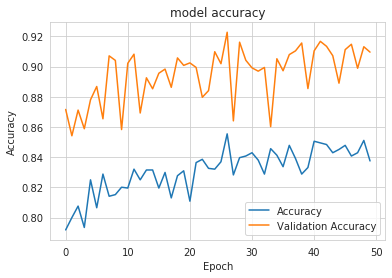

In [0]:
plt.plot(history1.history["acc"])
plt.plot(history1.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

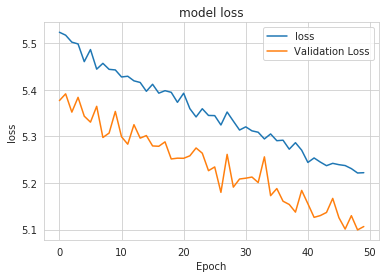

In [0]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

### Making Live Predictions

In [6]:
ft_model = load_model('/content/drive/My Drive/car_damage_detection/ft_model.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
def car_categories_gate(image_path, model):
    img = load_img(image_path, target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print("Validating that damage exists...")
    print(pred)
    if pred[0][0] <=.5:
        print("Validation complete - car is damaged")
    else:
        print("Car is not damaged.")
       

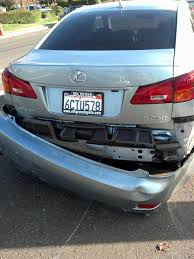

In [8]:
Image('/content/drive/My Drive/car_damage_detection/car1.JPEG')

In [9]:
car_categories_gate('/content/drive/My Drive/car_damage_detection/car1.JPEG', ft_model)

Validating that damage exists...
[[0.02599609]]
Validation complete - car is damaged


In [10]:
car_categories_gate('/content/drive/My Drive/car_damage_detection/test1.jpg', ft_model)

Validating that damage exists...
[[0.8816804]]
Car is not damaged.


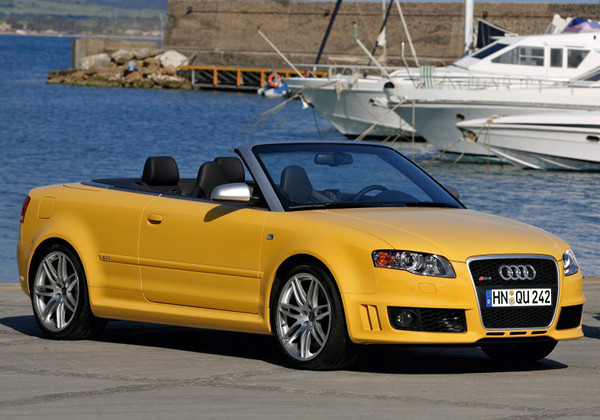

In [11]:
Image('/content/drive/My Drive/car_damage_detection/test1.jpg')